In [ ]:
import pandas as pd #TO import and manage datasets
import glob
import os
from google.colab import drive
drive.mount('/content/drive')
import re
import os
import csv
import requests
from bs4 import BeautifulSoup as bs
import requests


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
grouped_df = pd.read_csv("/content/drive/MyDrive/dissertation/grouped_player_df3.csv")
test_df = pd.read_csv("/content/drive/MyDrive/testdata.csv")

print("total number of rows before data cleaning")
print(grouped_df.shape)


total number of rows before data cleaning
(15773, 178)


<ipython-input-47-b1a4eff590b8>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  grouped_df = pd.read_csv("/content/drive/MyDrive/dissertation/grouped_player_df3.csv")


In [ ]:

#filtering based on minutes column
grouped_df = grouped_df.dropna(subset=['minutes'])
grouped_df = grouped_df[grouped_df['minutes'] >= 90]
test_df = test_df.dropna(subset=['minutes'])
test_df = test_df[test_df['minutes'] >= 50]
grouped_df = grouped_df[grouped_df['player'] != 'Ronaldo Vieira']
grouped_df = grouped_df.drop(grouped_df[grouped_df['position'] == "0"].index)

In [ ]:
def alter_pos(pos_df):

    pos_df = pos_df.drop(pos_df[pos_df['position'] == "GK"].index)
    """pos_df = pos_df.drop(pos_df[pos_df['position'] == "DF,GK"].index)


    condition = pos_df['position'] == "MF,FW"
    pos_df.loc[condition, 'position'] = 'MF'

    condition = pos_df['position'] == "FW,MF"
    pos_df.loc[condition, 'position'] = 'FW'

    condition = pos_df['position'] == "DF,FW"
    pos_df.loc[condition, 'position'] = 'DF'

    condition = pos_df['position'] == "FW,DF"
    pos_df.loc[condition, 'position'] = 'FW'

    condition = pos_df['position'] == "DF,MF"
    pos_df.loc[condition, 'position'] = 'DF'

    condition = pos_df['position'] == "MF,DF"
    pos_df.loc[condition, 'position'] = 'MF'"""

    return pos_df

grouped_df = alter_pos(grouped_df)
test_df = alter_pos(test_df)
counts = test_df['position'].astype(str).value_counts()

# Plot the bar graph


In [ ]:
#imputing value manually for missing nationality
condition = grouped_df['player'] == "Alessio da Cruz"
grouped_df.loc[condition, 'nationality'] = "nl NED"

grouped_df = grouped_df.fillna(0)
print("total number of rows after data cleaning")
print(grouped_df.shape)

total number of rows after data cleaning
(10748, 178)


In [ ]:
test_df = test_df.fillna(0)

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
target_column = 'goals'

# Select other columns for correlation calculation
other_columns = grouped_df.columns.difference([target_column])

# Calculate correlations
correlations = grouped_df[other_columns].corrwith(grouped_df[target_column])
print("correlation value are ", correlations)
# Create a new DataFrame for correlation results
correlation_df = pd.DataFrame(correlations)
correlation_df = pd.DataFrame(correlations, columns=['Correlation'])
print(correlation_df.describe())

filtered_correlation_df = correlation_df[correlation_df['Correlation'] > 0.5]

# Convert the filtered DataFrame to a dictionary
correlation_dict = filtered_correlation_df.to_dict()

print("Correlation results:")
print(correlation_dict)
filtered_correlation_df.to_csv("/content/drive/MyDrive/dissertation/corr_attackers_goal.csv")

correlation value are  Unnamed: 0                               0.010207
Unnamed: 0.1                             0.000056
aerials_lost                             0.434859
aerials_won                              0.217569
aerials_won_pct                         -0.154895
assisted_shots                           0.531195
assists                                  0.517457
assists_per90                            0.280280
average_shot_distance                   -0.027685
ball_recoveries                          0.119006
birth_year                              -0.065701
blocked_passes                           0.232889
blocked_shots                           -0.114756
blocks                                   0.117347
cards_red                               -0.001661
cards_yellow                             0.102522
cards_yellow_red                        -0.009443
carries                                  0.248376
carries_distance                         0.283157
carries_into_final_third   

<ipython-input-7-3fcf22e54824>:9: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = grouped_df[other_columns].corrwith(grouped_df[target_column])


In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/dissertation/goal_corr.csv")
df = pd.read_csv("/content/drive/MyDrive/dissertation/corr_attackers_goal.csv")
#sum_values = df['Correlation'].sum()
print(df)
# Normalize the values to add up to 100
#df['normalized_column'] = (df['Correlation'] / sum_values) * 100

#df.columns = ['column', 'correlation', 'weight']
selected_columns = ['column','weight']
weights_df = pd.DataFrame(df[selected_columns])

weights = dict(zip(weights_df['column'], weights_df['weight']))
print(weights)

                         column  Correlation  weight
0                         goals     0.777317      18
1                           gca     0.647763       8
2   progressive_passes_received     0.660323       9
3                     pens_made     0.617797       8
4                       assists     0.722532      14
5               shots_on_target     0.631466       6
6     carries_into_penalty_area     0.635923       6
7      goals_per_shot_on_target          NaN       6
8                assisted_shots     0.531195       5
9                      take_ons     0.512773       5
10    crosses_into_penalty_area          NaN       5
11                        shots     0.574119       4
12                     pens_att     0.631583       6
13                        games          NaN       4
14                      minutes          NaN       2
15         touches_att_pen_area     0.837030       4
16                    sca_shots     0.692366       7
17              aerials_won_pct    -0.154895  

In [ ]:
from scipy.stats import zscore
def rating(df,weights):
  selected = weights_df['column'].values.tolist()
  print(selected)
  attackers_df = df[selected]
  #attackers_df.fillna(0)
  attackers_df.fillna(0, inplace=True)

  players_name_df = df[['player']]
  z_scores_attackers_df = attackers_df.apply(zscore)
  #print(z_scores_attackers_df)
  #correlation based weight generation

  total_weight = sum(weights.values())
  #print(total_weight)
  weights_percentage = {k: v / total_weight for k, v in weights.items()}

  # Step 3: Multiply data with the importance weights
  attackers_cols = attackers_df.columns
  for col in attackers_cols:
      z_scores_attackers_df[col] = (z_scores_attackers_df[col] * (weights_percentage[col] ) * 10)

  # Step 4: Calculate overall ratings as percentage-based scores
  z_scores_attackers_df['attacker_rating'] = z_scores_attackers_df.sum(axis=1)


  # Sort players based on their overall rating (highest to lowest)
  df['attacker_rating']=z_scores_attackers_df['attacker_rating']
  #z_scores_attackers_df = z_scores_attackers_df.sort_values(by='attacker_rating', ascending=False)

  attackers_df['attacker_rating']=z_scores_attackers_df['attacker_rating']
  label_print = ['player','attacker_rating']
  print_df = pd.DataFrame(df[label_print])
  results_df = print_df.sort_values(by='attacker_rating', ascending=False)
  print(results_df[['player', 'attacker_rating']])
  print(results_df.head(10))
  #results_df.to_csv("/content/drive/MyDrive/dissertation/check_attacker_df.csv")
  #print(print_df)

  return attackers_df

In [ ]:
rated = rating(grouped_df,weights)
grouped_df['attacker_rating']=rated['attacker_rating']


['goals', 'gca', 'progressive_passes_received', 'pens_made', 'assists', 'shots_on_target', 'carries_into_penalty_area', 'goals_per_shot_on_target', 'assisted_shots', 'take_ons', 'crosses_into_penalty_area', 'shots', 'pens_att', 'games', 'minutes', 'touches_att_pen_area', 'sca_shots', 'aerials_won_pct', 'sca', 'sca_fouled', 'touches_att_3rd', 'dispossessed', 'miscontrols', 'offsides', 'own_goals', 'cards_yellow_red']
                  player  attacker_rating
1659        Lionel Messi        69.646953
7641        Lionel Messi        65.771597
6507   Cristiano Ronaldo        64.636073
4608        Lionel Messi        63.337961
6478       Ciro Immobile        63.262197
...                  ...              ...
1857       Mario Hermoso       -14.651461
3515         Conor Coady       -14.785214
4673       Lucas Tousart       -14.848562
13384       Franco Russo       -15.396981
4043      Gustavo Cabral       -15.577909

[10748 rows x 2 columns]
                  player  attacker_rating
1659    

<ipython-input-52-3528e7e299de>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attackers_df.fillna(0, inplace=True)
<ipython-input-52-3528e7e299de>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attackers_df['attacker_rating']=z_scores_attackers_df['attacker_rating']


In [ ]:
rated = rating(test_df,weights)
test_df['attacker_rating'] = rated['attacker_rating']

['goals', 'gca', 'progressive_passes_received', 'pens_made', 'assists', 'shots_on_target', 'carries_into_penalty_area', 'goals_per_shot_on_target', 'assisted_shots', 'take_ons', 'crosses_into_penalty_area', 'shots', 'pens_att', 'games', 'minutes', 'touches_att_pen_area', 'sca_shots', 'aerials_won_pct', 'sca', 'sca_fouled', 'touches_att_3rd', 'dispossessed', 'miscontrols', 'offsides', 'own_goals', 'cards_yellow_red']
                   player  attacker_rating
1145        Kylian Mbappé        57.951358
968        Jonathan David        50.395162
1192         Lionel Messi        45.771745
95    Alexandre Lacazette        44.506737
2079      Vinicius Júnior        42.963494
...                   ...              ...
2186       Édgar González       -13.073548
2111            Wout Faes       -13.103792
1469       Milan Škriniar       -13.229991
911        Jeison Murillo       -13.470912
1807                 Ruan       -17.162144

[1830 rows x 2 columns]
                     player  attacker_r

<ipython-input-52-3528e7e299de>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attackers_df.fillna(0, inplace=True)
<ipython-input-52-3528e7e299de>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attackers_df['attacker_rating']=z_scores_attackers_df['attacker_rating']


In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
test_df['position']

0          MF
2          DF
3          FW
4       MF,FW
5       FW,MF
        ...  
2196       MF
2197       DF
2199       MF
2200       MF
2203    FW,MF
Name: position, Length: 1830, dtype: object

In [ ]:
def rem_gk_cols(df):

  columns_to_drop = ['gk_avg_distance_def_actions','gk_clean_sheets','gk_clean_sheets_pct','gk_corner_kick_goals_against','gk_crosses_stopped','gk_def_actions_outside_pen_area','gk_def_actions_outside_pen_area_per90','gk_free_kick_goals_against','gk_games','gk_games_starts','gk_goal_kick_length_avg','gk_goal_kicks','gk_goals_against','gk_goals_against_per90','gk_losses','gk_minutes','gk_own_goals_against','gk_passes','gk_passes_completed_launched','gk_passes_launched','gk_passes_length_avg','gk_passes_pct_launched','gk_passes_throws','gk_pct_goal_kicks_launched','gk_pct_passes_launched','gk_pens_allowed','gk_pens_att','gk_pens_missed','gk_pens_save_pct','gk_pens_saved','gk_psnpxg_per_shot_on_target_against','gk_psxg','gk_psxg_net','gk_psxg_net_per90','gk_save_pct','gk_saves','gk_shots_on_target_against','gk_ties','gk_wins','gk_crosses','gk_crosses_stopped_pct']

  # Drop the specified GK columns
  mod_df = df.drop(columns=columns_to_drop)
  return mod_df

In [ ]:
def select_cols(df,weights):
  selected = weights_df['column'].values.tolist()
  attack_df = df[selected]
  return attack_df

In [ ]:
train_data = grouped_df.copy()
train_df = select_cols(train_data,weights)
train_df['attacker_rating'] = train_data['attacker_rating']

<ipython-input-57-40040d35d7e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['attacker_rating'] = train_data['attacker_rating']


In [ ]:
test_data = test_df.copy()
X_test_df = select_cols(test_data,weights)
X_test_df['attacker_rating'] = test_data['attacker_rating']

<ipython-input-58-10a0d8210998>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['attacker_rating'] = test_data['attacker_rating']


In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                print("(" + corr_matrix.columns[i] +"," + corr_matrix.columns[j]+ ")")
    return col_corr

In [ ]:
corr_features = correlation(train_df, 0.95)
print(corr_features)

(shots,shots_on_target)
(pens_att,pens_made)
(sca,assisted_shots)
{'sca', 'pens_att', 'shots'}


In [ ]:
corr_features = correlation(train_df, 0.95)
X_train_corr = train_df.drop(corr_features, axis=1)
X_test_corr = X_test_df.drop(corr_features, axis=1)
n_features3 = X_train_corr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

(shots,shots_on_target)
(pens_att,pens_made)
(sca,assisted_shots)
After removing 3 features, there are 24 features left.


In [ ]:
from sklearn.preprocessing import StandardScaler
def scale(df):
  scaler = StandardScaler()
  scaler.fit(df)
  scaled_features = scaler.transform(df)
  df_feat = pd.DataFrame(scaled_features,columns=df.columns)
  df_feat.head()
  return df_feat

In [ ]:
X_train = scale(X_train_corr)
X_test = scale(X_test_corr)
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

In [ ]:
print(type(y_test))

In [ ]:
X_test.shape

In [ ]:
train_data.to_csv("/content/drive/MyDrive/dissertation/train_data_pre.csv")

In [ ]:
def select_cols_disp(df,weights):
  selected = weights_df['column'].values.tolist()
  if 'player' not in selected:
    selected.append('player')
  if 'year' not in selected:
    selected.append('year')

  if "age" not in selected:
    selected.append('age')
  if "team" not in selected:
    selected.append('team')
  attack_df = df[selected]
  return attack_df

In [ ]:
def knn_modelling(X_train,index):
    from sklearn.neighbors import NearestNeighbors
    import matplotlib.pyplot as plt
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics.pairwise import cosine_similarity
    nn = NearestNeighbors(n_neighbors=10,metric='minkowski',p=2)
    #,metric='minkowski',p=1
    nn.fit(X_train)
    import numpy as np
    print("data used in model",X_train.iloc[index])
    # Find the nearest neighbors of a data point in the X_test dataset
    test = np.array(X_train.iloc[index])
      #row = test_player[test_player['position'] == "Lionel Messi"]
      #print(row)
    #test = stats.iloc[34]
    test = test.reshape(-1, 24)
    #test = np.array(X_test.iloc[index])

    print(test)
    distances, indices = nn.kneighbors(test)
    print("test data:",train_data.iloc[index])
    print("Indices of Nearest Neighbors:")
    print(indices)

    print("\nDistances to Nearest Neighbors:")
    print(distances)
    train_indices_predicted = indices[0]
    list_display = []
    for ind in train_indices_predicted:
        list_display.append(train_data.iloc[ind])

    disp_df = pd.DataFrame(list_display)

    list_df = select_cols_disp(disp_df,weights)
    print(list_df)
    #!pip install lime

    predicted_list=[]

    for ind in train_indices_predicted:
        predicted_list.append(X_train.iloc[ind])

    scaled_vis_df = pd.DataFrame(predicted_list)
    """ from sklearn.decomposition import PCA
    pca = PCA(n_components=2)  # Specify the number of components to keep
    pca_result = pca.fit_transform(X_train)

  # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    print("indices are",pca_df.index)
    pca_df['highlight'] = pca_df.index.isin(scaled_vis_df.index)

    highlighted_points = pca_df[pca_df['highlight']]
    non_highlighted_points = pca_df[~pca_df['highlight']]

    print(pca_df)
    # Visualize the PCA results using a scatter plot
    plt.figure(figsize=(8, 6))

    # Scatter plot for non-highlighted points
    plt.scatter(
        pca_df[pca_df['highlight'] == False]['PC1'],
        pca_df[pca_df['highlight'] == False]['PC2'],
        c='blue',
        label='PCA Reduced Data'
    )

    # Scatter plot for highlighted points
# Scatter plot for highlighted points
    highlighted_points = pca_df[pca_df['highlight']]
    for i, point in highlighted_points.iterrows():
        plt.scatter(
            point['PC1'],
            point['PC2'],
            c='red',

        )



    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Results')
    plt.legend()
    plt.show()


    #pairplot(train_indices_predicted,X_train,index,X_test)"""

In [ ]:
knn_modelling(X_train,10314)#aubmayeng suggestion - gabrieljesus
#knn_modelling(X_train,7042) #wijnaldum suggestion - naby keita
#knn_modelling(X_train,4609) #ronaldo suggestions
#knn_modelling(X_train,5378) #messi suggestions
#knn_modelling(X_train,2622) #hazard
#knn_modelling(X_train,1414) #mesut ozil likes of odegaard

data used in model goals                          9.048827
gca                            2.520693
progressive_passes_received    2.978202
pens_made                      5.632774
assists                        0.685145
shots_on_target                8.004265
carries_into_penalty_area      1.292511
goals_per_shot_on_target       0.668036
assisted_shots                 1.381205
take_ons                       1.893403
crosses_into_penalty_area     -0.071649
games                          1.250673
minutes                        1.653459
touches_att_pen_area           5.598549
sca_shots                      5.307316
aerials_won_pct                0.109935
sca_fouled                     2.820996
touches_att_3rd                2.120745
dispossessed                   2.495992
miscontrols                    2.619784
offsides                       3.297479
own_goals                     -0.238218
cards_yellow_red              -0.263243
attacker_rating                5.181664
Name: 10314, dtype: f

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
y1_target = pd.DataFrame(train_data['position'])

y_train = cat_pos(y1_target)
y2_target = pd.DataFrame(test_data['position'])
y_test = cat_pos(y2_target)
print(y_test)

In [ ]:
grouped_data = pd.read_csv("/content/drive/MyDrive/dissertation/grouped_player_df3.csv")
test_data = pd.read_csv("/content/drive/MyDrive/testdata.csv")
#filtering based on minutes column
grouped_data = grouped_data.dropna(subset=['minutes'])
grouped_data = grouped_data[grouped_data['minutes'] >= 90]
test_data = test_data.dropna(subset=['minutes'])
test_data = test_data[test_data['minutes'] >= 50]
grouped_data = grouped_data[grouped_data['player'] != 'Ronaldo Vieira']
grouped_data = grouped_data.drop(grouped_data[grouped_data['position'] == "0"].index)
grouped_data.shape

<ipython-input-67-b63165cf5811>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  grouped_data = pd.read_csv("/content/drive/MyDrive/dissertation/grouped_player_df3.csv")


(11726, 178)

In [ ]:
def alter_pos(pos_df):

    pos_df = pos_df.drop(pos_df[pos_df['position'] == "GK"].index)
    pos_df = pos_df.drop(pos_df[pos_df['position'] == "DF,GK"].index)
    """pos_df = pos_df.drop(pos_df[pos_df['position'] == "DF,GK"].index)


    condition = pos_df['position'] == "MF,FW"
    pos_df.loc[condition, 'position'] = 'MF'

    condition = pos_df['position'] == "FW,MF"
    pos_df.loc[condition, 'position'] = 'FW'

    condition = pos_df['position'] == "DF,FW"
    pos_df.loc[condition, 'position'] = 'DF'

    condition = pos_df['position'] == "FW,DF"
    pos_df.loc[condition, 'position'] = 'FW'

    condition = pos_df['position'] == "DF,MF"
    pos_df.loc[condition, 'position'] = 'DF'

    condition = pos_df['position'] == "MF,DF"
    pos_df.loc[condition, 'position'] = 'MF'"""

    return pos_df

grouped_data = alter_pos(grouped_data)
test_data = alter_pos(test_data)
#counts = test_df['position'].astype(str).value_counts()

# Plot the bar graph
print("total number of rows after data cleaning")
print(grouped_data.shape)

total number of rows after data cleaning
(10748, 178)


In [ ]:
#imputing value manually for missing nationality
condition = grouped_data['player'] == "Alessio da Cruz"
grouped_data.loc[condition, 'nationality'] = "nl NED"

print("total number of rows after data cleaning")
print(grouped_data.shape)

total number of rows after data cleaning
(10748, 178)


In [ ]:
columns_to_drop = ['gk_avg_distance_def_actions','gk_clean_sheets','gk_clean_sheets_pct','gk_corner_kick_goals_against','gk_crosses_stopped','gk_def_actions_outside_pen_area','gk_def_actions_outside_pen_area_per90','gk_free_kick_goals_against','gk_games','gk_games_starts','gk_goal_kick_length_avg','gk_goal_kicks','gk_goals_against','gk_goals_against_per90','gk_losses','gk_minutes','gk_own_goals_against','gk_passes','gk_passes_completed_launched','gk_passes_launched','gk_passes_length_avg','gk_passes_pct_launched','gk_passes_throws','gk_pct_goal_kicks_launched','gk_pct_passes_launched','gk_pens_allowed','gk_pens_att','gk_pens_missed','gk_pens_save_pct','gk_pens_saved','gk_psnpxg_per_shot_on_target_against','gk_psxg','gk_psxg_net','gk_psxg_net_per90','gk_save_pct','gk_saves','gk_shots_on_target_against','gk_ties','gk_wins','gk_crosses','gk_crosses_stopped_pct']

print("total number of rows before cleaning")
print(grouped_data.shape)
# Drop the specified GK columns
grouped_data = grouped_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

print("after dropping",grouped_data.shape)


total number of rows before cleaning
(10748, 178)
after dropping (10748, 137)


aerials_won_pct               48
average_shot_distance        457
blocked_passes                30
blocked_shots                 30
blocks                        30
cards_yellow_red               1
challenge_tackles             30
challenge_tackles_pct        166
challenges                    30
challenges_lost               30
clearances                    30
errors                        30
goals_per_shot               456
goals_per_shot_on_target    1703
minutes_per_start           1353
minutes_per_sub             2467
passes_pct_long               62
tackles                       30
tackles_att_3rd               30
tackles_def_3rd               30
tackles_interceptions         30
tackles_mid_3rd               30
dtype: int64


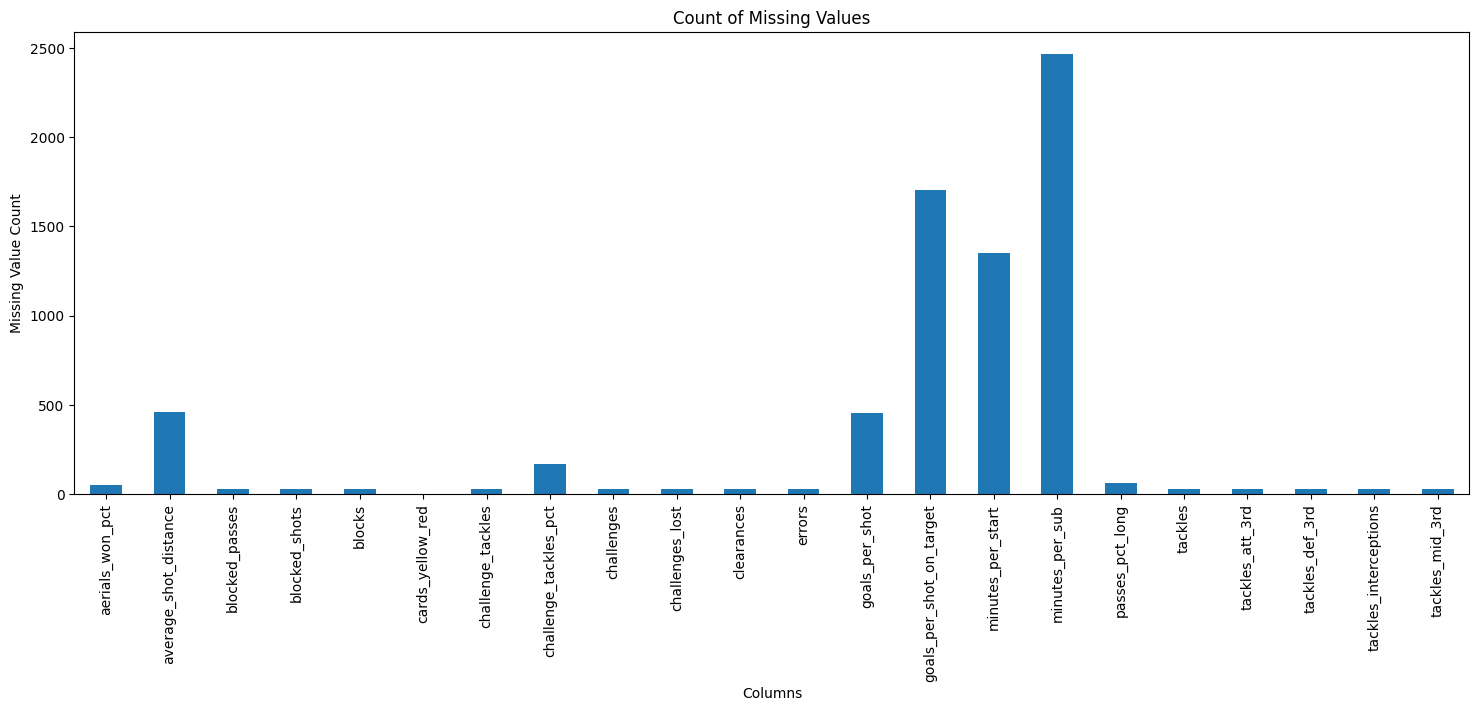

In [ ]:
import matplotlib.pyplot as plt
missing_values = grouped_data.isnull().sum()
missing_values_filtered = missing_values[missing_values > 0]
print(missing_values_filtered)
missing_values_filtered.plot(kind='bar', figsize=(18, 6))
plt.title('Count of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.show()

In [ ]:
import pandas as pd


# Condition for dropping rows (e.g., rows where 'column_name' is equal to 30)
condition = (grouped_data['year'] == "2021-2022")

# Drop rows based on the condition
train_data = grouped_data[~condition]

# Display the resulting DataFrame
print("after dropping test rows from training data", train_data.shape)
print("after dropping test rows from training data", test_data.shape)

after dropping test rows from training data (8572, 137)
after dropping test rows from training data (1830, 136)


In [ ]:
counts = y_train_cat['position'].astype(str).value_counts()
import matplotlib.pyplot as plt

# Plot the bar graph
plt.bar(counts.index, counts.values)
plt.xlabel('Column1')
plt.ylabel('Count')
plt.show()

NameError: ignored

In [ ]:
X_train_pos = train_data.drop(['Unnamed: 0','Unnamed: 0.1','player', 'position','team', 'year', 'nationality','birth_year','competition'], axis=1)
X_test_pos = test_data.drop(['Unnamed: 0','player', 'position','team', 'year', 'nationality','birth_year','competition'], axis=1)


<ipython-input-73-b3b267e73b77>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X_train_pos.corr()


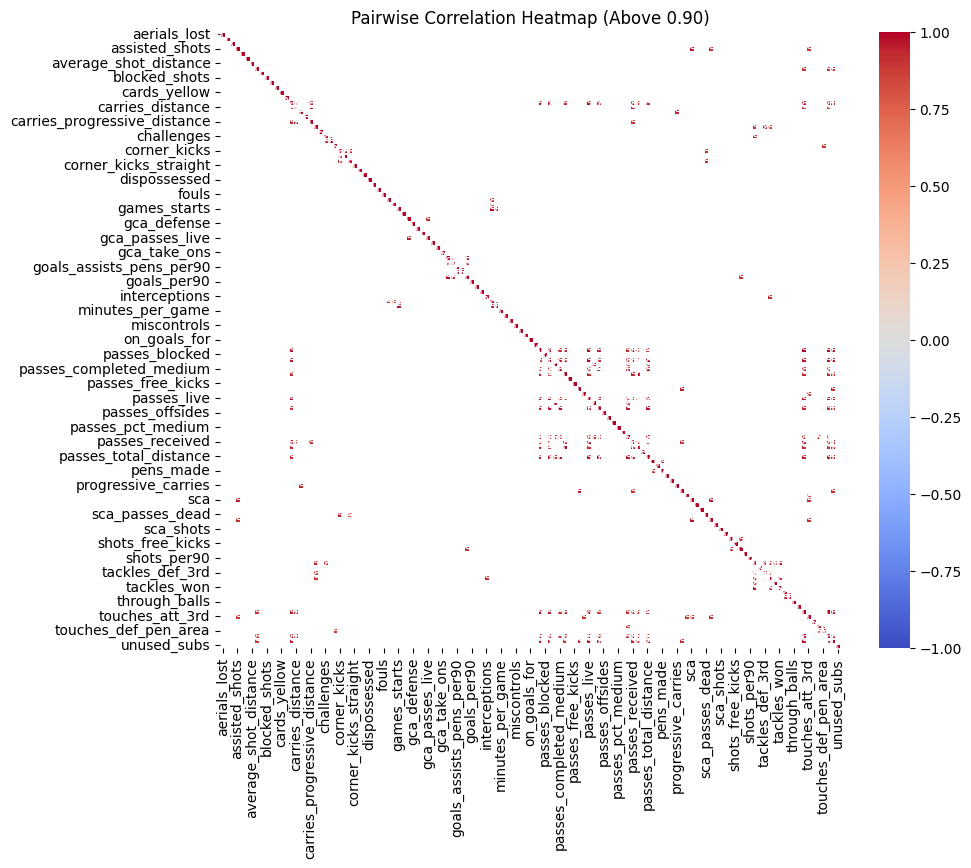

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X_train_pos.corr()

# Create a mask to hide correlations below 0.90
mask = correlation_matrix.abs() <= 0.90

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with the masked values
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask,
            vmin=-1, vmax=1, center=0, linewidths=0.5)

plt.title("Pairwise Correlation Heatmap (Above 0.90)")
plt.show()


In [ ]:
corr_features_pos = correlation(X_train_pos, 0.90)
print(type(corr_features_pos))

<ipython-input-59-062d3719a8ad>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


(carries_distance,carries)
(carries_progressive_distance,carries)
(carries_progressive_distance,carries_distance)
(challenges_lost,challenges)
(corner_kicks_in,corner_kicks)
(corner_kicks_out,corner_kicks)
(gca_passes_live,gca)
(goals_assists,goals)
(goals_assists_per90,goals_assists_pens_per90)
(goals_pens,goals)
(goals_pens,goals_assists)
(minutes,games)
(minutes,games_complete)
(minutes,games_starts)
(minutes_90s,games_starts)
(minutes_90s,minutes)
(passes,carries)
(passes_completed,carries)
(passes_completed,passes)
(passes_completed_medium,passes)
(passes_completed_medium,passes_completed)
(passes_completed_short,carries)
(passes_completed_short,passes)
(passes_completed_short,passes_completed)
(passes_live,carries)
(passes_live,passes)
(passes_live,passes_completed)
(passes_live,passes_completed_medium)
(passes_live,passes_completed_short)
(passes_long,passes_completed_long)
(passes_medium,carries)
(passes_medium,passes)
(passes_medium,passes_completed)
(passes_medium,passes_comp

In [ ]:
corr_features_pos
corr_features_to_rem = [
 'carries',
 'carries_progressive_distance',
 'challenges',
 'challenges_lost',

 'goals_assists',
 'goals_pens',
 'minutes',
 'miscontrols',
 'passes',
 'passes_completed',
 'pens_made',
 'progressive_carries',
 'progressive_passes',
 'sca',
 'shots_on_target',
 'tackles',
 'tackles_def_3rd',
 'tackles_interceptions',
 'tackles_mid_3rd',
 'tackles_won',
 'take_ons_tackled',
 'touches',
 'touches_att_3rd',
 'touches_att_pen_area',
 'touches_def_3rd',
 'touches_live_ball',
 'touches_mid_3rd']

In [ ]:

X_train_corr_pos = X_train_pos.drop(corr_features_to_rem, axis=1)
X_test_corr_pos = X_test_pos.drop(corr_features_to_rem, axis=1)
n_features_pos = X_train_corr_pos.shape[1]
print(f'After removing {len(corr_features_to_rem)} features, there are {n_features_pos} features left.')

After removing 27 features, there are 101 features left.


In [ ]:
X_train_corr_pos['age'] = X_train_corr_pos['age'].apply(lambda x: int(float(str(x).split("-")[0])))
X_test_corr_pos['age'] = X_test_corr_pos['age'].apply(lambda x: int(float(str(x).split("-")[0])))

In [ ]:
X_train_scaled = scale(X_train_corr_pos)
X_test_scaled = scale(X_test_corr_pos)
X_train_scaled.fillna(0,inplace=True)
X_test_scaled.fillna(0,inplace=True)

In [ ]:
def cat_pos(pos_df):


  pos_df['position'] = pos_df['position'].map({
    "MF,FW": 1,
    "FW,MF": 2,
    "DF,FW": 3,
    "FW,DF": 2,
    "DF,MF": 3,
    "MF,DF": 1,
    "MF": 1,
    "DF": 3,
    "FW": 2
  }).fillna(0).astype(int)

  return pos_df

In [ ]:
y1_target_pos = pd.DataFrame(train_data['position'])

y_train_cat = cat_pos(y1_target_pos)
y2_target_pos = pd.DataFrame(test_data['position'])
y_test_cat = cat_pos(y2_target_pos)
print(y_test_cat)

      position
0            1
2            3
3            2
4            1
5            2
...        ...
2196         1
2197         3
2199         1
2200         1
2203         2

[1830 rows x 1 columns]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled,y_train_cat)
pred_pos = knn.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print(type(y_train_cat))
print(y_test_cat.shape)
print(type(pred_df))
print(pred_df.shape)

<class 'pandas.core.frame.DataFrame'>
(1830, 1)
<class 'pandas.core.frame.DataFrame'>
(1830, 1)


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test_cat,pred_pos))
print(classification_report(y_test_cat,pred_pos))

[[517  72  36]
 [101 347   7]
 [ 58  14 678]]
              precision    recall  f1-score   support

           1       0.76      0.83      0.79       625
           2       0.80      0.76      0.78       455
           3       0.94      0.90      0.92       750

    accuracy                           0.84      1830
   macro avg       0.84      0.83      0.83      1830
weighted avg       0.85      0.84      0.84      1830



In [ ]:
pred_df = pd.DataFrame(pred_pos)

pred_df = pred_df.rename(columns={pred_df.columns[0]: "position"})
print(y_test_cat)

y_test_cat = y_test_cat.reset_index(drop=True)
pred_df = pred_df.reset_index(drop=True)

# Now, you can compare the DataFrames
comparison = y_test_cat == pred_df

# Check if any values are not equal
print(comparison)
import numpy as np
row_indices,col_indices = np.where(comparison == False)
print(row_indices)
# Create a list of tuples containing (row index, column index)
indices_with_false_values = list(row_indices)

# Check if all values are equal (True)
print(indices_with_false_values)


      position
0            1
2            3
3            2
4            1
5            2
...        ...
2196         1
2197         3
2199         1
2200         1
2203         2

[1830 rows x 1 columns]
      position
0         True
1         True
2         True
3         True
4         True
...        ...
1825      True
1826      True
1827      True
1828      True
1829     False

[1830 rows x 1 columns]
[   7   15   25   40   51   60   65   76   77   78   80   89   98  103
  107  114  137  141  147  173  174  179  180  183  185  189  197  198
  214  244  245  254  259  263  269  271  280  283  290  300  304  314
  322  333  346  347  364  367  370  376  401  408  413  418  419  420
  429  435  453  466  471  477  482  484  488  489  490  494  495  497
  503  507  511  512  529  531  538  539  547  548  549  550  552  558
  560  564  567  572  574  577  580  595  598  600  613  626  630  655
  662  669  676  683  685  691  694  696  710  718  720  721  725  728
  733  745  757  762  

In [ ]:
orig_data = train_data.copy()
orig_data = orig_data.reset_index(drop=True)
alternate_pos_df = orig_data.iloc[indices_with_false_values]
alternate_pos_df['suggested_position'] = pred_df['position']
test_data.to_csv("/content/drive/MyDrive/dissertation/test_pos.csv")

<ipython-input-28-e0f2daca3ca0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alternate_pos_df['suggested_position'] = pred_df['position']


xshape (1830, 2)
yshape (1830, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


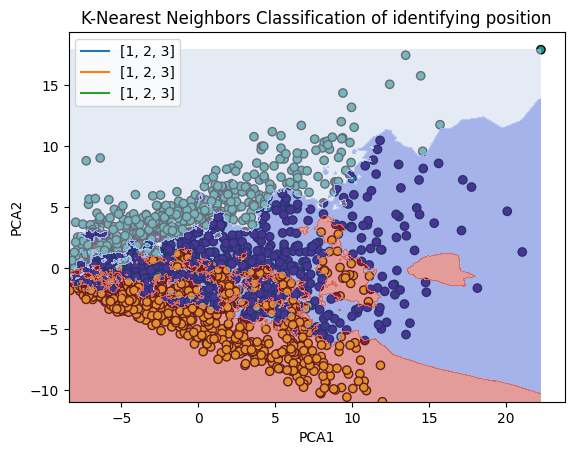

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification


print("xshape",X_pca.shape)
print("yshape",y_test_cat.shape)

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

# Create a KNN classifier
knn_p = KNeighborsClassifier(n_neighbors=8)
knn_p.fit(X_pca, y_test_cat)# Calculate the distances to the nearest neighbors for each data point

pred_y_test = knn_p.predict(X_pca)
"""
# Plot the data points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_y_test,edgecolor='k')
labels = [1,2,3]
# Label the clusters
for i in range(len(labels)):
    plt.plot(
        [X_pca[i, 0].min(), X_pca[i, 0].max()],
        [X_pca[i, 1].min(), X_pca[i, 1].max()],
        label=labels,
    )

plt.title("K-Nearest Neighbors Classification of identifying position")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()"""


# Plot the data points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_y_test,edgecolor='k')
labels = [1,2,3]
# Label the clusters
for i in range(len(labels)):
    plt.plot(
        [X_pca[i, 0].min(), X_pca[i, 0].max()],
        [X_pca[i, 1].min(), X_pca[i, 1].max()],
        label=labels,
    )

# Generate the decision boundary
x_min, x_max = X_pca[:, 0].min(), X_pca[:, 0].max()
y_min, y_max = X_pca[:, 1].min(), X_pca[:, 1].max()
h = 0.01

# Create a meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class labels for each point in the meshgrid
Z = knn_p.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted class labels
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)

plt.title("K-Nearest Neighbors Classification of identifying position")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
age_counts = train_data['age'].value_counts()

age_bins = [15, 23, 28, float('inf')]  # [young, senior, old]
age_labels = ['young', 'senior', 'old']

# Create a new column with age categories
train_data['age_category'] = pd.cut(train_data['age'], bins=age_bins, labels=age_labels)

# Count the occurrences of each age category
age_category_counts = train_data['age_category'].value_counts()

plt.figure(figsize=(10, 6))
age_category_counts.sort_index().plot(kind='bar', color='blue')
plt.title('Count of Age Values')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [ ]:
test_data.to_csv("/content/drive/MyDrive/dissertation/test_data_pre.csv")

In [ ]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer



In [ ]:
type(X_test_scaled)

pandas.core.frame.DataFrame

In [ ]:
X_test_scaled[0]

KeyError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

knn_lime = KNeighborsClassifier(n_neighbors=7)
knn_lime.fit(X_train_scaled,y_train_cat)


# Create the explainer
explainer = LimeTabularExplainer(X_train_scaled.values, feature_names=X_train_scaled.columns.tolist(), class_names=np.unique(y_train_cat),
                                 discretize_continuous=False)

# Choose a data point for which you want to explain the prediction (e.g., the first data point in the test set)
data_point_idx = 15

instance_to_explain = X_test_scaled.iloc[data_point_idx]
class_to_explain = 0
# Generate the explanation for the selected data point
explanation = explainer.explain_instance(instance_to_explain, knn_lime.predict_proba, num_features=len(X_train_scaled.columns),labels=[class_to_explain])

predicted_probabilities = knn_lime.predict_proba([instance_to_explain])
predicted_class = np.argmax(predicted_probabilities)
print("Classified as:", predicted_class)
#print("orig position is",test_df.iloc[instance_to_explain,'position'])
# Show the explanation

explanation.show_in_notebook(show_table=True)


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Classified as: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
np.unique(y_train_cat)

array([1, 2, 3])